# Jupyter Notebook Classification Sample Tutorial

# Preface: How to Use this Jupyter Notebook Tutorial
Below is a sequence of boxes referred to as "cells".  Each cell will contain text, like this one, or Python code that may be executed as part of this tutorial.  As you go through this turoial, please note the following:

### Running the Tutorial
You can always use either the "Run" button at the top or **Shift+Enter** to execute a selected cell, starting with this one, and then automatically move to the next cell.

   **Note**: If you happen to press just **Enter**, you will enter the editing mode for the cell.  To exit and continue, use **Shift+Enter**.  
   
Unless stated otherwise, the cells containing code within this tutorial **MUST** be executed in sequence.

You may save the tutorial at any time which will save the output, but not state.  Saved Jupyter Notebooks will save sequence numbers which may make a cell appear executed when it has not been for the new session.  Because state is not saved, re-opening or restarting a Jupyter Notebook will required re-executing all the executable steps starting from the beginning.

If for any reason you need to restart the tutorial from the beginning, you may reset the state of the Jupyter Notebook and clear all output by using the menu at the top by selecting **Kernel->"Restart and Clear Output"**

### Cells Containing Executable Code
Executable cells will have "In [n]:" to the left of the cell:
- If 'n' is blank (no number), it means that the cell has not yet been executed.  
- If 'n' is '*', it means that the cell is currently executing.  
- Once a cell is done executing, 'n' will appear as a number incrementing with each cell execution to indicate where in the sequence the cell has been executed.  Any output (e.g. print()'s) from the code will appear below the cell.
    - Note: If you need to stop a cell during execution, for example during a long video, you can use the "Stop" button at the top (square to the right of the "Run" button).  After stopping the cell, you may re-execute it if needed.

# Prerequisites
Before going through this tutorial, please be sure that:
- All files from the .zip file containing the tutorial are present and in the same directory.  The required files are:
    - tutorial_classification_sample.ipynb - This Jupyter Notebook
    - squeezenet1.1/squeezenet1.1.bin and squeezenet1.1/squeezenet1.1.xml - The IR files for the inference model created using Model Optimizer
    - squeezenet1.1/squeezenet1.1.labels.txt - mapping of numerical labels to text strings
    - dog.jpg - test image
    - cat.jpg - test image
    - bird.jpg - test image
    - libcpu_extension.so - pre-compiled CPU extension library
    - doc_*.png - images used in the documentation
- Optional: URL to image to run inference on

**Note:** It is assumed that the server this tutorial is being run on has Jupyter Notebook, OpenVINO toolkit, and other required libraries already installed.  If you download or copy to a new server, the tutorial may not run.  

# Introduction
The purpose of this tutorial is to examine a sample application that was created using the [Intel® Distribution of Open Visual Inference & Neural Network Optimization (OpenVINO™) toolkit](https://software.intel.com/openvino-toolkit).  This tutorial will go step-by-step through the necessary steps to demonstrate object classification on images and batches of images.  Classification is performed using a pre-trained network and running it using the OpenVINO™ toolkit Inference Engine.  Inference will be executed using the same CPU(s) running this Jupyter Notebook.

The pre-trained model to be used for object detection is the ["squeezenet1.1"](https://github.com/DeepScale/SqueezeNet/) which has already been converted to the necessary Intermediate Representation (IR) files needed by the Inference Engine (Conversion is not covered here, please see the [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/en-us/openvino-toolkit) documentation for more details).  The model is capable of classifying and reporting the probability of 1000 different objects including different species of cats, dogs, birds, insects, etc. (see squeezenet1.1/squeezenet1.1.labels.txt file for complete list).  

# Key Concepts
Before going into the samples in the tutorial steps, first we will go over some key concepts that will be covered in this tutorial.

## OpenVINO™ Toolkit Overview and Terminology 

Let us begin with a brief overview of the OpenVINO™ toolkit and what this tutorial will be covering.  The OpenVINO™ toolkit enables the quick deployment of convolutional neural networks (CNN) for heterogeneous execution on Intel® hardware while maximizing performance. This is done using the Intel® Deep Learning Deployment Toolkit (Intel® DL Deployment Toolkit) included within the OpenVINO™ toolkit with its main components shown below.

![image alt text](./doc_openvino_overview_image.png)

The basic flow is:

1. Use a tool, such as Caffe, to create and train a CNN inference model

2. Run the created model through Model Optimizer to produce an optimized Intermediate Representation (IR) stored in files (.bin and .xml) for use with the Inference Engine

3. The User Application then loads and runs models on devices using the Inference Engine and the IR files  

This tutorial will focus on the last step, the User Application and using the Inference Engine to run a model on CPU.

### Using the Inference Engine

Below is a more detailed view of the User Application and Inference Engine:

![image alt text](./doc_inference_engine_image.png)

The Inference Engine includes a plugin library for each supported device that has been optimized for the Intel® hardware device CPU, GPU, and Myriad.  From here, we will use the terms "device" and “plugin” with the assumption that one infers the other (e.g. CPU device infers the CPU plugin and vice versa).  As part of loading the model, the User Application tells the Inference Engine which device to target which in turn loads the associated plugin library to later run on the associated device. The Inference Engine uses “blobs” for all data exchanges, basically arrays in memory arranged according the input and output data of the model.

#### Inference Engine API Integration Flow

Using the Inference Engine API follows the basic steps outlined briefly below.  The API objects and functions will be seen later in the sample code.

1. Load the plugin

2. Read the model IR

3. Load the model into the plugin

6. Prepare the input

7. Run Inference

8. Process the output

More details on the Inference Engine can be found in the [Inference Engine Development Guide](https://software.intel.com/inference-engine-devguide)

## Input Preprocessing

Often, the dimensions of the input data does not match the required dimensions of the input data for the inference model.  A common example is an input video frame.  Before the image may be input to the inference model, the input must be preprocessed to match the required dimensions for the inference model as well as channels (i.e. colors) and batch size (number of images present).  The basic step performed is to resize the frame from the source dimensions to match the required dimensions of the inference model’s input, reorganizing any dimensions as needed.

This tutorial and the many samples in the OpenVINO™ toolkit use OpenCV to perform resizing of input data.  The basic steps performed using OpenCV are:

1.  Resize image dimensions form image to model's input W x H:
    frame = cv2.resize(image, (w, h))
   
2. Change data layout from (H x W x C) to (C x H x W)
    frame = frame.transpose((2, 0, 1))  

3. Reshape to match input dimensions
    frame = frame.reshape((n, c, h, w))

## Batch Size
Batch size refers to the number of input data to be inferred during a single inference run through the Inference Engine.  Things to be aware of the batch size for an inference model:

### Batch Size and Its Effects on Input and Output Data is Model Dependent

* The output batch size may scale with input batch size.  For example, the classification model used in this tutorial will have one one output for each input.

* The output may contain results across all batched inputs.  For example, the oject detection model used in 
the **Jupyter Notebook Object Detection Sample Tutorial** gives one set of outputs regardless of input batch size, with each output indicating to which input the results belong.

### How Batch Size is Set

* The default setting is located in the model’s IR which is set either by:

   * The Model Optimizer command line option when creating the IR files

   * Or from the original source (e.g. Caffe) in which can be read using the Inference Engine API 

* Batch size may be set explicitly using the Inference Engine API setting *batch_size* field of the created IENetwork object.  Later in the **Inferring Input Images in Batches** section of this tutorial, converting from a single input image to a batch of input images will be shown to highlight the differences.

## Performance Counters
During inference execution, performance counts (metrics) are kept per layer.  Included with the counts, are the time spent and the "execution type" that indicates which device the layer was executed.  The performance counts may be retrieved from an internal request object after inference has completed and calling *get_perf_counts()*.  An example is shown in the **Report Performance Counters** step of this tutorial.

# Sample Application
Now we will begin going through the sample application.

## Importing Python Modules
Here we begin by importing all the Python modules that will be used by the sample code:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [cv2](https://docs.opencv.org/trunk/) - OpenCV module
- [time](https://docs.python.org/3/library/time.html#module-time) - time tracking module (used for measuring execution time)
- [numpy](http://www.numpy.org/) - n-dimensional array manipulation
- [openvino.inference_engine](https://software.intel.com/en-us/articles/OpenVINO-InferEngine) - import the IENetwork and IEPlugin objects
- [matplotlib](https://matplotlib.org/) - import pyplot used for displaying output images

In [1]:
import os
import cv2
import time
import numpy as np
from openvino.inference_engine import IENetwork, IEPlugin
from matplotlib import pyplot as plt
%matplotlib inline
print("Imported Python modules.")

Imported Python modules.


## Configuration Parameters
Here we will create and set the following configuration parameters used by the sample:  
* *model_xml* - Path to the .xml IR file of the trained model to use for inference
* *model_bin* - Path to the .bin IR file of the trained model to use for inference (derived from *model_xml*)
* *input_path* - Path to input image
* *cpu_extension_path* - Path to a shared library with CPU extension kernels for custom layers not already included in plugin
* *device* - Specify the target device to infer on,  CPU, GPU, FPGA, or MYRIAD is acceptable, however the device must be present.  For this tutorial we use "CPU" which is known to be present.
* *report_top_n* - Numbr of top-n classification results to report
* *labels_path* - Path to labels mapping file used to map outputted integers to strings (e.g. 7="car")

We will set all parameters here only once except for *input_path* which we will change later to point to different images.

In [2]:
# model IR files
model_xml = "./squeezenet1.1/squeezenet1.1.xml"
model_bin = "./squeezenet1.1/squeezenet1.1.bin"

# input image file
input_path = "./dog.jpg"
   
# CPU extension library to use
cpu_extension_path = "libcpu_extension.so"

# device to use
device = "CPU"

# number of top results to display
report_top_n = 10

# output labels 
labels_path = "./squeezenet1.1/squeezenet1.1.labels"

print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tinput_path=", input_path,
      "\n\tcpu_extension_path=", cpu_extension_path, 
      "\n\tdevice=", device, 
      "\n\tlabels_path=", labels_path, 
      "\n\treport_top_n=", report_top_n)

Configuration parameters settings:
	model_xml= ./squeezenet1.1/squeezenet1.1.xml 
	model_bin= ./squeezenet1.1/squeezenet1.1.bin 
	input_path= ./dog.jpg 
	cpu_extension_path= libcpu_extension.so 
	device= CPU 
	labels_path= ./squeezenet1.1/squeezenet1.1.labels 
	report_top_n= 10


## Create Plugin for Device
Here we create a plugin object for the specified device using IEPlugin().  
If the plugin is for a CPU device, and the *cpu_extensions_path* variable has been set, we load the extensions library. 

In [3]:
# create plugin for device
plugin = IEPlugin(device=device)
print("A plugin object has been created for device [", plugin.device, "]\n")

# if the device is CPU and a path to an extension library is set, load the extension library 
#if cpu_extension_path and 'CPU' in device:
#    plugin.add_cpu_extension(cpu_extension_path)
#    print("CPU extension [", cpu_extension_path, "] has been loaded")

A plugin object has been created for device [ CPU ]

CPU extension [ libcpu_extension.so ] has been loaded


## Create Network from Model IR files
Here we create a *IENetwork* object and load the model's IR files into it.  After loading the model, we check to make sure that all the model's layers are supported by the plugin we will use.  We also check to make sure that the model's input and output are as expected for later when we run inference.

In [4]:
# load network from IR files
net = IENetwork(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sure that the plugin has support for all layers in the loaded model
supported_layers = plugin.get_supported_layers(net)
not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
if len(not_supported_layers) != 0:
    print("ERROR: Following layers are not supported by the plugin for specified device {}:\n {}".
             format(plugin.device, ', '.join(not_supported_layers)))
    if not cpu_extension_path:
        print("       Please try specifying the cpu extensions library path by setting the 'cpu_extension_path' variable")
    assert 0 == 1, "ERROR: Missing support for all layers in th emodel, cannot continue."

# check to make sue that the model's input and output are what is expected
assert len(net.inputs.keys()) == 1, "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

Loaded model IR files [ ./squeezenet1.1/squeezenet1.1.bin ] and [ ./squeezenet1.1/squeezenet1.1.xml ]

SUCCESS: Model IR files have been loaded and verified


## Load the Model into the Device Plugin
Here we load the model network into the plugin so that we may run inference.  *exec_net* will be used later to actually run inference.  After loading, we store the names of the input (*input_blob*) and output (*output_blob*) blobs to use when accessing the input and output blobs of the model.  Lastly, we store the model's input dimensions into the following variables:
- *n* = input batch size
- *c* = number of input channels (here 1 channel per color R,G, and B)
- *h* = input height
- *w* = input width

In [5]:
# load the model into the plugin
exec_net = plugin.load(network=net, num_requests=2)

# store name of input and output blobs
input_blob = next(iter(net.inputs))
output_blob = next(iter(net.outputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.inputs[input_blob].shape
print("Loaded model into plugin.  Model input dimensions: n=",n,", c=",c,", h=",h,", w=",w)

Loaded model into plugin.  Model input dimensions: n= 1 , c= 3 , h= 227 , w= 227


## Load Label Map 
For each detected object, the output from the model will include an integer to indicate which type (e.g. daisy, bee, etc.) of trained object has been detected.  To translate the integer into a more readable text string, a label mapping file may be used.  The label mapping file is simply a text file where the line number is used for the index into a lookup table to be used later while reporting detected objects.

Here, if the *labels_path* variable has been set to point to a label mapping file, we open the file and load the labels into the variable *labels_map*.

In [6]:
labels_map = None
# if labels points to a label mapping file, then load the file into labels_map
print(labels_path)
if os.path.isfile(labels_path):
    with open(labels_path, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
    print("Loaded label mapping file [",labels_path,"]")
else:
    print("No label mapping file has been loaded, only numbers will be used for detected object labels")

./squeezenet1.1/squeezenet1.1.labels
Loaded label mapping file [ ./squeezenet1.1/squeezenet1.1.labels ]


## Prepare Input Image
Here we read and then prepare the input image by resizing and re-arranging its dimensions according to the model's input dimensions.  We define functions the *loadInputImage()* and *resizeInputImage()* for the operations so that we may reuse them again later in the tutorial.

Loaded input image [ ./dog.jpg ], resolution= 3124.0 w x  4020.0 h
Resized input image from (4020, 3124) to (227, 227)
Input image:


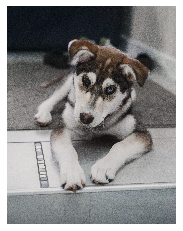

In [7]:
# define function to load an input image
def loadInputImage(input_path):
    # globals to store input width and height
    global input_w, input_h
    
    # use OpenCV to load the input image
    cap = cv2.VideoCapture(input_path) 
    
    # store input width and height
    input_w = cap.get(3)
    input_h = cap.get(4)
    print("Loaded input image [",input_path,"], resolution=", input_w, "w x ",input_h,"h")

    # load the input image
    ret, image = cap.read()
    del cap
    return image

# define function for resizing input image
def resizeInputImage(image):
    # resize image dimensions form image to model's input w x h
    in_frame = cv2.resize(image, (w, h))
    # Change data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))  
    # reshape to input dimensions
    in_frame = in_frame.reshape((n, c, h, w))
    print("Resized input image from {} to {}".format(image.shape[:-1], (h, w)))
    return in_frame

# load image
image = loadInputImage(input_path)

# resize the input image
in_frame = resizeInputImage(image)

# display input image
print("Input image:")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Run Inference
Now that we have the input image in the correct format for the model, we now run inference on the input image.

In [8]:
# save start time
inf_start = time.time()

# run inference
res = exec_net.infer(inputs={input_blob: in_frame})   

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

Inference complete, run time: 8.635 ms


## Process and Display Results
Now we process the inference results by sorting all the possible classes by the probability assigned during inference, then selecting and displaying the top *report_top_n* items.  We define the function *processAndDisplayResults()* so that we may use it again later in the tutorial to process results.

Top  10  results for image ./dog.jpg :
Probability% is <label>
 0.5759334 % is husky
 0.0870907 % is malemute, Alaskan malamute
 0.0668216 % is pug-dog
 0.0602475 % is Chihuahua
 0.0477892 % is dog, husky
 0.0363472 % is cat
 0.0139815 % is ferret, ferret, Mustela nigripes
 0.0100679 % is retriever
 0.0088881 % is cat
 0.0071303 % is beagle


Processed and displayed inference output results.


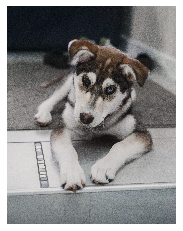

In [9]:
# create function to process inference results
def processAndDisplayResults(probs, orig_input_image, orig_input_path):
    # display image
    plt.figure()
    plt.axis("off")
    im_to_show = cv2.cvtColor(orig_input_image, cv2.COLOR_BGR2RGB)

    # report top n results for image
    print("Top ", report_top_n, " results for image",orig_input_path,":")
    
    # remove dimensions of length=1
    probs = np.squeeze(probs)
    
    # sort then return top report_top_n entries
    top_ind = np.argsort(probs)[-report_top_n:][::-1]
    
    # show input image
    plt.imshow(im_to_show)
    
    # print out top probabilities, lookiing up label
    print("Probability% is <label>")
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print(" {:.7f} % is {}".format(probs[id], det_label))
    print("\n")

processAndDisplayResults(res[output_blob][0], image, input_path)
print("Processed and displayed inference output results.")

# Exercise #1: Run a Different Image
Now that we have seen all the steps, let us run them again on a different image.  We also define *inferImage()* to combine the input processing, inference, and processing and displaying results so that we may use it again later in the tutorial.

Loaded input image [ cat.jpg ], resolution= 4482.0 w x  2988.0 h
Resized input image from (2988, 4482) to (227, 227)
Top  10  results for image cat.jpg :
Probability% is <label>
 0.7645624 % is tabby cat
 0.1004653 % is catamount
 0.0679075 % is cat
 0.0660864 % is cat
 0.0005517 % is Panthera tigris
 0.0001068 % is bathing tub, bath, tub
 0.0000408 % is triceratops
 0.0000387 % is terrier
 0.0000275 % is prairie wolf, brush wolf, Canis latrans
 0.0000270 % is vat




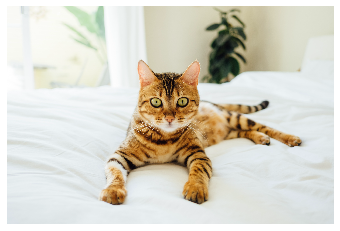

In [10]:
# define function to prepare input, run inference, and process inference results
def inferImage(image, input_path):
    # prepare input
    in_frame = resizeInputImage(image)

    # run inference
    res = exec_net.infer(inputs={input_blob: in_frame})   

    # process inference results 
    processAndDisplayResults(res[output_blob][0], image, input_path)

# set path to differnt input image
input_path="cat.jpg"

# load input image
image = loadInputImage(input_path)

# infer image and display results
inferImage(image, input_path)

# Exercise #2: (Optional) Run Your Own Image
Here you may run any image you would like by setting the *input_path* variable which may be set to a local file or URL.  A sample URL is provided as an example.

In [ ]:
# input_path may be set to a local file or URL
input_path = "https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg"

# load input image
image = loadInputImage(input_path)

# infer image and display results
inferImage(image, input_path)

## Inferring Input Images in Batches
We have seen how to run inference on a single input image, we will now see how to infer multiple input images in batches.  Inferring in batches follows the same steps as when inferring a single input image, including using a single call to perform inference, except that an array (batch) of inputs must be prepared and an array (batch) of outputs must be processed. 

### Preparing a Batch of Inputs
Preparing a batch of input images is much like when preparing a single image except that the input to inference is now an array of inputs.  Running multiple input images also means that arrays (*orig_image_paths* and *orig_images*) are needed to store input data to be used later.

In [ ]:
# batch of inputs which may be local files or URLs (comma separated)
batch_paths = ["./dog.jpg", "./cat.jpg", "./bird.jpg"]

# define function to load input images into input batch
def batchLoadInputImages(batch_paths):
    global batch_size
    global batch_images
    global orig_image_paths
    global orig_images
    batch_size = len(batch_paths)

    # create input batch (array) of input images 
    batch_images = np.ndarray(shape=(batch_size, c, h, w))

    # create array to hold original images and paths for displaying later
    orig_images = []
    orig_image_paths = []

    for i in range(batch_size):
        # load image
        image = loadInputImage(batch_paths[i])

        # save original image and path
        orig_images.append(image)
        orig_image_paths.append(batch_paths[i])

        # prepare input
        in_frame = resizeInputImage(image)

        # add input to batch
        batch_images[i] = in_frame
    return batch_size, batch_images, orig_image_paths, orig_images

batchLoadInputImages(batch_paths)
print("Loaded", batch_size, "images.")

### Running Inference on a Batch of Inputs
To process all the input images, the inference model needs to know how large the input array (batch) is.  Batch size is set using *IENetwork.batch_size=\< n \>*.  This will change the batch size of the network before it has been loaded into the plugin.  To get the change to take effect, we must reload the network into the plugin before running inference. 

In [ ]:
# set the batch size to match the number of input images
net.batch_size = batch_size
print("Network batch size set to", batch_size)

# reload network because batch size has changed 
exec_net = plugin.load(network=net)

# save start time
inf_start = time.time()

# run inference
res = exec_net.infer(inputs={input_blob: batch_images})   

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

### Processing and Displaying a Batch of Outputs

In [ ]:
# create function to process inference results
def batchProcessAndDisplayResults(result, orig_input_images, orig_image_paths):
    # get output results
    res = result[output_blob]

    for i, probs in enumerate(res):
        processAndDisplayResults(probs, orig_input_images[i], orig_image_paths[i])
        
# process inference results 
batchProcessAndDisplayResults(res, orig_images, orig_image_paths)

# Exercise #3: (Optional) Run Your Own Batch of Images
Here you may run any image you would like by setting the *input_paths* variable to an array of paths which may be set to a local file or URL.  A sample array is provided as an example.

In [ ]:
# batch of inputs which may be local files or URLs (comma separated)
batch_paths = ["https://cdn.pixabay.com/photo/2015/06/25/12/27/daisy-821222_1280.jpg", "./cat.jpg"]

# load batch of inputs
batchLoadInputImages(batch_paths)
print("Loaded", batch_size, "images.")

# set the batch size to match the number of input images
net.batch_size = batch_size
print("Network batch size set to", batch_size)

# reload network because batch size has changed 
exec_net = plugin.load(network=net)

# run inference
res = exec_net.infer(inputs={input_blob: batch_images})   

# process inference results 
batchProcessAndDisplayResults(res, orig_images, orig_image_paths)

print("Done.")

## Report Performance Counters
After running inference, the performance counters may be read from an internal request object using the function *get_perf_counts()* to see which layers of the inference model were run and how much time was spent in each.  Performance counts (metrics) reported include:
- name - Name of layer within the inference model
- layer_type - Type (or function) of layer (e.g. convolution, concat, etc.)
- exec_type - Execution type for the layer.  The name may be used to identify which device has been run.  For example, entries starting with "jit_" indicate the CPU was used.
- status - Whether the layer had been executed or not
- real_time - Time in microseconds spent running layer

In [ ]:
# retrieve performance counters from last inference request
perf_counts = exec_net.requests[0].get_perf_counts()

# display performance counters for each layer
print("Performance counters:")
print("{:<40} {:<15} {:<15} {:<15} {:<10}".format('name', 'layer_type', 'exec_type', 'status', 'real_time, us'))
for layer, stats in perf_counts.items():
    print("{:<40} {:<15} {:<15} {:<15} {:<10}".format(layer, stats['layer_type'], stats['exec_type'],
                                                          stats['status'], stats['real_time']))


# Exit: Free Resources
Now that we are done running the sample, we clean up by deleting objects before exiting.

In [ ]:
del exec_net
del plugin
del net

# End of Tutorial - Next Steps

### [More Jupyter Notebook Tutorials](https://access.colfaxresearch.com/?p=experience)
### [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit)